# Three Layer Neural Net

In [1]:
#Setup MPL (needs to be done before plt is imported)
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt

## Setup the data

In [3]:
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
with tf.name_scope('dataprep'):
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
print "Training data: ", mnist.train.images.shape
print "Testing data: ", mnist.test.images.shape
print "Validation data: ", mnist.validation.images.shape
print "28 * 28 = 784 pixels of greyscale data"

Training data:  (55000, 784)
Testing data:  (10000, 784)
Validation data:  (5000, 784)
28 * 28 = 784 pixels of greyscale data


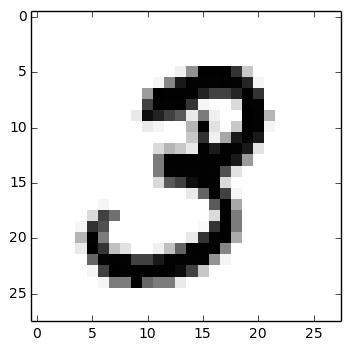

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
imgplot = ax.imshow(mnist.train.images[1].reshape(28,28), interpolation='nearest', cmap=mpl.cm.Greys)
plt.show()

## TF Model

In [6]:
# Network Topology
n_input    = 784
n_hidden_1 = 256
n_hidden_2 = 128 
n_classes  = 10

#Weight should be initialized from a Gaussian with standard deviation equal to weight_scale, 
#and biases should be initialized to zero
weight_scale=0.1

# Parameters
learning_rate = 0.001
batch_size = 100
display_step = 100
reg = 1e-6
num_epochs = 10
num_train = mnist.train.images.shape[0]
iterations_per_epoch = max(num_train / batch_size, 1)
num_iterations = num_epochs * iterations_per_epoch

In [7]:
print num_iterations
print iterations_per_epoch

5500
550


### Setup Graph

In [8]:
tf.reset_default_graph()
# Inputs
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, [None, 784], name="X-input")
    y = tf.placeholder(tf.float32, [None, 10], name="y-input")

# Weights (Variables)
with tf.name_scope('weights'):    
    layer1_W = tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=weight_scale), name="layer1_weights")
    layer1_b = tf.Variable(tf.zeros([n_hidden_1]), name="layer1_bias")
    #layer1_b = tf.Variable(tf.random_normal([n_hidden_1]), name="layer1_bias")
    layer2_W = tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=weight_scale), name="layer2_weights")
    layer2_b = tf.Variable(tf.zeros([n_hidden_2]), name="layer2_bias")
    #layer2_b = tf.Variable(tf.random_normal([n_hidden_2]), name="layer2_bias")
    layer3_W = tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=weight_scale), name="layer3_weights")
    layer3_b = tf.Variable(tf.zeros([n_classes]), name="layer3_bias")    
    #layer3_b = tf.Variable(tf.random_normal([n_classes]), name="layer3_bias")

# Operations
with tf.name_scope('Model'):
    layer1_activations = tf.nn.sigmoid(tf.matmul(X, layer1_W) + layer1_b)
    layer2_activations = tf.nn.sigmoid(tf.matmul(layer1_activations, layer2_W) + layer2_b)
    scores = tf.matmul(layer2_activations, layer3_W) + layer3_b

#better to use tf.nn.sparse_softmax_cross_entropy_with_logits
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(scores, y) ) #+ reg * tf.nn.l2_loss(layer3_W)

# Train
with tf.name_scope('train'):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)    

with tf.name_scope('trainPrediction'):
    prediction = tf.nn.softmax(scores)

with tf.name_scope('Accuracy'):
    # Accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(prediction,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('Summaries'):
    tr_loss_summary_op = tf.scalar_summary('training loss', loss)
    tr_acc_summary_op = tf.scalar_summary("training accuracy", accuracy)
    train_summary_op = tf.merge_summary([tr_loss_summary_op, tr_acc_summary_op])
    
    val_acc_summary_op = tf.scalar_summary("validation accuracy", accuracy)        

# Initializing the variables
with tf.name_scope('globalOps'):          
    init = tf.initialize_all_variables()   

## Execute graph

In [9]:
sess = tf.Session()
writer = tf.train.SummaryWriter('./ThreeLayerNet2', sess.graph)

sess.run(init)

# Training cycle
for step in xrange(num_iterations):
    minibatchX, minibatchy = mnist.train.next_batch(batch_size)        
    _ = sess.run([optimizer], feed_dict = {X:minibatchX, y:minibatchy})        
    
    #compute loss & accuracy and log to TensorBoard
    if (step % display_step == 0):
        _, tr_summ = sess.run([accuracy, train_summary_op], feed_dict = {X:minibatchX, y:minibatchy})
        _, val_summ = sess.run([accuracy, val_acc_summary_op], feed_dict = {X:mnist.validation.images, y:mnist.validation.labels})
        writer.add_summary(tr_summ, step)
        writer.add_summary(val_summ, step)    
    
#Final eval
print "Test Set Accuracy: ", sess.run(accuracy,feed_dict={X: mnist.test.images, y: mnist.test.labels})
print "done"

writer.flush()
writer.close()
sess.close()

Test Set Accuracy:  0.9772
done
